In [1]:
import os
import numpy
os.chdir("utils")
from burgers_utils import *
from plotting import plot_loss, list_tensor_to_list, three_plots_burgers, heat_map
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
file_path = '../data/burgers_shock.mat'

In [3]:
# loading data from the burgers_shock.mat
# usol in the paper's script has been reffered as Exact
x, t, usol = load_data(file_path)

In [4]:
# making a spatial-temporal grid
X, T = mesh_grid(x, t)

In [5]:
# Creating test data set
# X_test is reffered as X_star
# y_test is reffered as u_star
X_test, y_test = test_data(X, T, usol)

In [6]:
# Domain bounds 
lb, ub = domain_bounds(X_test)

In [7]:
# Number of collocation points i.e. number of training points for f
N_f = 10000
# Number of initial and boudary conditions to train the model for u
N_u = 100

In [8]:
### In Physics-informed neural networks, we are predicting a latent variable u (x,t) and structure of 
### the pde f(u,x, t). variables with "u_train" in them corresponds to the training example required for u 
### and "f_train" corresponds to the training example required for f
### We don't have "y_f_train" because it's value is always zero and we specified it in the loss function

In [9]:
# In the the paper they are reffered as X_u_train, X_f_train and u_train
x_f, x_u, y_u = training_data(X, T, usol, lb, ub, N_f)

In [10]:
# From the entire initial and boundary conditions we will select N_u number of x,t,u for the training
idx = np.random.choice(x_u.shape[0], N_u, replace=False)
X_u_train = x_u[idx, :]
y_u_train = y_u[idx, :]
# Stacking collocation points and IC and BC condtions
# this will be used for imposing the structure of the Partial Differential Equation
X_f_train = np.vstack([x_f, X_u_train])

In [11]:
# Specifying the number of layers in the neural network shared between u and f
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Specifying the coefficient of viscosity
nu = 0.01/np.pi

In [12]:
def shared_model_func(layers, lb=None, ub=None, norm=False):
    '''
    shared_model_func: function creates a multilayer perceptron network for the shared network (u and f)
    Arguments:
    layers-- a list which contains of units in each layer
    Returns:
    model-- return a untrained keras model
    '''
    # u and f are function of x and t so creating 2 variables
    x =  tf.keras.Input(shape=[1,], dtype=tf.float64)
    t =  tf.keras.Input(shape=[1,], dtype=tf.float64)

    # Concating x and t so we can make an array of [x,t]
    inputs = tf.keras.layers.concatenate([x, t],dtype=tf.float64)
    # If want to standardize our data
    if norm==True:
        # Data pre-processing
        # Standardizing the data
        inputs = 2.0 * (inputs - lb)/(ub - lb) - 1.0
    # Xavier initializer and seed was not paper in the original paper but we set it as 1234
    # In case, TA wants to reproduce the results so they can do it
    initializer = tf.keras.initializers.glorot_normal(seed = 1234)
    for layer in layers[1:-1]:
        inputs = tf.keras.layers.Dense(units=int(layer),
                                       activation='sigmoid' ,
                                       kernel_initializer=initializer,
                                       dtype=tf.float64,
                                      trainable=True)(inputs)
#         inputs = tf.keras.layers.LeakyReLU(alpha=0.7)(inputs)

    outputs = tf.keras.layers.Dense(units=int(layers[-1]),
                                    activation='linear',
                                    kernel_initializer=initializer,
                                    dtype=tf.float64,
                                   trainable=True)(inputs)

    model = tf.keras.models.Model(inputs=[x,t], outputs=outputs)
    return model



In [13]:
# Creating a shared neural network
shared_model = shared_model_func(layers=layers, 
                                  lb=lb,
                                   ub = ub,
                                    norm = True) 
print("Shared network summary is: \n")
shared_model.summary()

Shared network summary is: 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 2)]          0           

In [14]:
# Specified in the paper
loss_function = tf.keras.losses.MeanSquaredError()
# Working perfect 
# 1. choose_optimizer(lr=5e-02, ds=100, er=0.96, opt='Adam')
# 2. choose_optimizer(lr=1e-02, ds=100, er=0.96, opt='RMSprop')
optimizer = choose_optimizer(lr=5*1e-03, ds=100, er=0.955, opt='Adam', lear_rate_sched=True)
train_dataset = data_gen(X_f_train, batch_size=X_f_train.shape[0])
max_Iter = 10000
loss_u = []
loss_f = []
loss_model = []
for epoch in tqdm(range(max_Iter)):
    for (X_f_train, t_f_train) in train_dataset:   
        # Passing the entire data in a single batch (That's how they did in the original paper)
        loss_1, loss_2, loss_combine = model_build_compile(x_f=X_f_train, t_f=t_f_train, 
                                                           x_u = X_u_train[:,0:1], t_u = X_u_train[:,1:2],
                                                           u = y_u_train, shared_model=shared_model, 
                                                           loss_function=loss_function,
                                                           optimizer=optimizer)
        loss_u.append(loss_1)
        loss_f.append(loss_2)
        loss_model.append(loss_combine)
        
        if ((epoch+1)%1000 == 0):
            print("After {0} epochs loss on variable u is {1}".format(epoch+1, loss_1.numpy()))
            print("After {0} epochs loss on PDE structure (f) is {1}".format(epoch+1, loss_2.numpy()))
            print("After {0} epochs combined loss is {1}".format(epoch+1, loss_combine.numpy()))
            
        

  0%|          | 0/10000 [00:00<?, ?it/s]

 10%|█         | 1004/10000 [00:26<03:39, 40.89it/s]

After 1000 epochs loss on variable u is 0.14446496963500977
After 1000 epochs loss on PDE structure (f) is 4.79409791296348e-05
After 1000 epochs combined loss is 0.1445129106141394


 20%|██        | 2004/10000 [00:50<03:15, 40.84it/s]

After 2000 epochs loss on variable u is 0.14321213960647583
After 2000 epochs loss on PDE structure (f) is 9.73108981270343e-05
After 2000 epochs combined loss is 0.14330945050460286


 30%|███       | 3004/10000 [01:14<02:51, 40.72it/s]

After 3000 epochs loss on variable u is 0.004302185960114002
After 3000 epochs loss on PDE structure (f) is 0.005169125739485025
After 3000 epochs combined loss is 0.009471311699599028


 40%|████      | 4004/10000 [01:37<02:27, 40.76it/s]

After 4000 epochs loss on variable u is 0.0016167396679520607
After 4000 epochs loss on PDE structure (f) is 0.002565195318311453
After 4000 epochs combined loss is 0.0041819349862635136


 50%|█████     | 5004/10000 [02:01<02:02, 40.75it/s]

After 5000 epochs loss on variable u is 0.0007110353326424956
After 5000 epochs loss on PDE structure (f) is 0.0013601487735286355
After 5000 epochs combined loss is 0.002071184106171131


 60%|██████    | 6004/10000 [02:25<01:38, 40.75it/s]

After 6000 epochs loss on variable u is 0.0004163526464253664
After 6000 epochs loss on PDE structure (f) is 0.0008269117097370327
After 6000 epochs combined loss is 0.001243264356162399


 70%|███████   | 7004/10000 [02:48<01:12, 41.06it/s]

After 7000 epochs loss on variable u is 0.0002784564276225865
After 7000 epochs loss on PDE structure (f) is 0.0005849486333318055
After 7000 epochs combined loss is 0.000863405060954392


 80%|████████  | 8004/10000 [03:12<00:48, 40.84it/s]

After 8000 epochs loss on variable u is 0.00019828909717034549
After 8000 epochs loss on PDE structure (f) is 0.00045149473589845
After 8000 epochs combined loss is 0.0006497838330687955


 90%|█████████ | 9005/10000 [03:36<00:24, 41.21it/s]

After 9000 epochs loss on variable u is 0.0001553526963107288
After 9000 epochs loss on PDE structure (f) is 0.0003823211300186813
After 9000 epochs combined loss is 0.0005376738263294101


100%|██████████| 10000/10000 [04:00<00:00, 41.59it/s]

After 10000 epochs loss on variable u is 0.00012785526632796973
After 10000 epochs loss on PDE structure (f) is 0.00033809535671025515
After 10000 epochs combined loss is 0.0004659506230382249


In [15]:
# os.mkdir('../figures/Burgers_relu')

In [16]:
def plot_loss(num_epoch, y_list, which):
    '''
    plot_loss: function plots the different losses in a same fig
    Arguments:
    num_epoch-- specify the number of epochs
    y_list-- a list which contains the list of tensorflow loss
    which-- specifies 'burgers' or 'schrodinger'
    Returns:
    None
    '''
    xlab = r"Number of epochs"
    ylab = r"Loss"
    a = min(num_epoch, len(y_list[0]))
    x = np.linspace(start = 0, stop = a,
            num = a, dtype = np.int)
    if which == 'burgers':
        labels = [r"$loss_u$", r"$loss_f$", r"$loss_{model}$"]
        color = ['k','r', 'g' ]
        i = 0
        plt.figure(figsize=(6,4))
        for loss in y_list:
            loss_num = list_tensor_to_list(loss)
            loss_num = list_tensor_to_list(loss)
            plt.plot(x, loss_num, color[i], label=labels[i])
            i += 1
        plt.yscale('log')
        plt.xlabel(xlab, fontsize=10)
        plt.ylabel(ylab, fontsize=10)
        plt.legend(loc='best',fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.xlim([0, a])
        plt.savefig('../figures/Burgers_sigmoid/burgers_loss.png', dpi=500)
        plt.show()

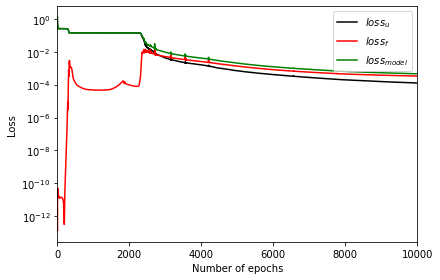

In [17]:
loss_list = [loss_u, loss_f, loss_model]
plot_loss(num_epoch=max_Iter, y_list=loss_list, which='burgers')

In [18]:
y_hat = predict(shared_model, X_test)

In [19]:
loss = error_loss(y_test, y_hat)
print("*****************************************************\n")
print("Error for the latent variable u is: {:e}".format(loss))
print("\n*****************************************************")

*****************************************************

Error for the latent variable u is: 3.276913e-02

*****************************************************


In [20]:
def three_plots_burgers(x, y, y_hat):
    '''
    plot_loss: function plots the snapshots of the solution at different time
    Arguments:
    x-- spatial grid (256, 1)
    y-- ground truth solution
    y_hat-- predicted solution
    Returns:
    None
    '''
    plt.figure(figsize=(6, 4))
    fig, (ax1, ax2, ax3)  = plt.subplots(1, 3,
                                    sharey='row')

    ax1.plot(x,y[25,:], 'b-', linewidth = 2, label = 'Exact')
    ax1.plot(x,y_hat[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$u(t,x)$')
    ax1.set_title('$t = 0.25$', fontsize = 10)
    ax1.axis('square')
    ax1.set_xlim([-1.1,1.1])
    ax1.set_ylim([-1.1,1.1])


    ax2.plot(x,y[50,:], 'b-', linewidth = 2, label = 'Exact')
    ax2.plot(x,y_hat[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$u(t,x)$')
    ax2.axis('square')
    ax2.set_xlim([-1.1,1.1])
    ax2.set_ylim([-1.1,1.1])
    ax2.set_title('$t = 0.50$', fontsize = 10)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax3.plot(x,y[75,:], 'b-', linewidth = 2, label = 'Exact')
    ax3.plot(x,y_hat[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$u(t,x)$')
    ax3.axis('square')
    ax3.set_xlim([-1.1,1.1])
    ax3.set_ylim([-1.1,1.1])
    ax3.set_title('$t = 0.75$', fontsize = 10)
    plt.savefig('../figures/Burgers_sigmoid/burgers_3.png', dpi=500)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

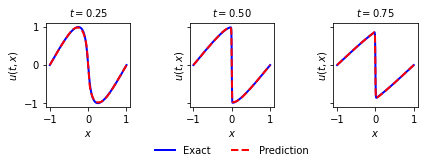

In [21]:
U_pred = griddata(X_test, y_hat.flatten(), (X, T), method='cubic')
three_plots_burgers(x, usol, U_pred)

In [22]:
def heat_map(U_pred, t, x, X_u_train, str):
    fig, ax = plt.subplots()
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(t,x)$', fontsize = 10)
    fig.savefig('../figures/Burgers_sigmoid/{}'.format(str))

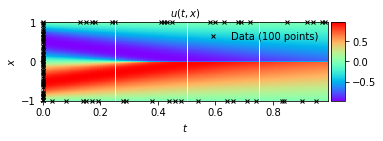

In [23]:
#Predicted solution on spatio-temporal grid
heat_map(U_pred, t, x, X_u_train, 'solution_heatmap')

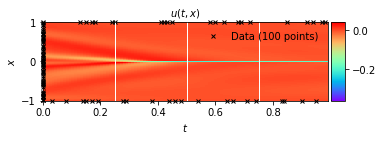

In [24]:
# Error of the solution on spatio-temporal grid
U_true  = griddata(X_test, y_test.flatten(), (X, T), method='cubic')
Error = U_pred - U_true
heat_map(Error, t, x, X_u_train, 'error_heatmap')